In [1]:
# Import Modules

import os
import pickle
import numpy as np

from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

2025-04-20 18:07:05.068970: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745172425.387065      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745172425.461563      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
BASE_DIR = '/kaggle/input/image-caption'
WORKING_DIR = '/kaggle/working'

In [3]:
# Extract Image Features
# load vgg16 model
model = VGG16()  # this skips downloading but the model won't be pre-trained
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

I0000 00:00:1745172465.679405      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745172465.680103      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [4]:
from PIL import Image

features = {}
directory = os.path.join(BASE_DIR, 'Images', 'Images')  # <- Based on your directory structure

for img_name in tqdm(os.listdir(directory)):
    img_path = os.path.join(directory, img_name)

    # Skip if it's a directory or not a valid image
    if not os.path.isfile(img_path) or not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue

    try:
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        image = preprocess_input(image)
        feature = model.predict(image, verbose=0)
        image_id = img_name.split('.')[0]
        features[image_id] = feature
    except Exception as e:
        print(f"Skipping {img_name}: {e}")


  0%|          | 0/8090 [00:00<?, ?it/s]

I0000 00:00:1745172519.086006      93 service.cc:148] XLA service 0x7f68f0004ae0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745172519.086867      93 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745172519.086888      93 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745172519.239377      93 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1745172521.951105      93 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [11]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [12]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [15]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [16]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [17]:
len(mapping)

8091

In [19]:
import re

def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.
            caption = re.sub('[^A-Za-z]', ' ', caption)
            # delete additional spaces
            caption = re.sub('\s+', ' ', caption)
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption


In [20]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [22]:
# Preprocess the text
clean(mapping)

In [24]:
# Filter only image IDs that exist in extracted features
train = [key for key in mapping.keys() if key in features]

In [25]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq startseq child in pink dress is climbing up set of stairs in an entry way endseq endseq',
 'startseq startseq girl going into wooden building endseq endseq',
 'startseq startseq little girl climbing into wooden playhouse endseq endseq',
 'startseq startseq little girl climbing the stairs to her playhouse endseq endseq',
 'startseq startseq little girl in pink dress going into wooden cabin endseq endseq']

In [27]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [28]:
# No. of unique captions stored
len(all_captions)

40455

In [29]:
all_captions[:10]

['startseq startseq child in pink dress is climbing up set of stairs in an entry way endseq endseq',
 'startseq startseq girl going into wooden building endseq endseq',
 'startseq startseq little girl climbing into wooden playhouse endseq endseq',
 'startseq startseq little girl climbing the stairs to her playhouse endseq endseq',
 'startseq startseq little girl in pink dress going into wooden cabin endseq endseq',
 'startseq startseq black dog and spotted dog are fighting endseq endseq',
 'startseq startseq black dog and tri colored dog playing with each other on the road endseq endseq',
 'startseq startseq black dog and white dog with brown spots are staring at each other in the street endseq endseq',
 'startseq startseq two dogs of different breeds looking at each other on the road endseq endseq',
 'startseq startseq two dogs on pavement moving toward each other endseq endseq']

In [30]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [31]:
vocab_size

8427

In [32]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

37

In [33]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [38]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    while True:
        X1, X2, y = [], [], []
        n = 0
        for key in data_keys:
            if key not in features:
                continue  # skip missing features
            n += 1
            caption_list = mapping[key]
            for caption in caption_list:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                # ✅ Return as a tuple instead of a list
                yield ((np.array(X1), np.array(X2)), np.array(y))
                X1, X2, y = [], [], []
                n = 0


In [39]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

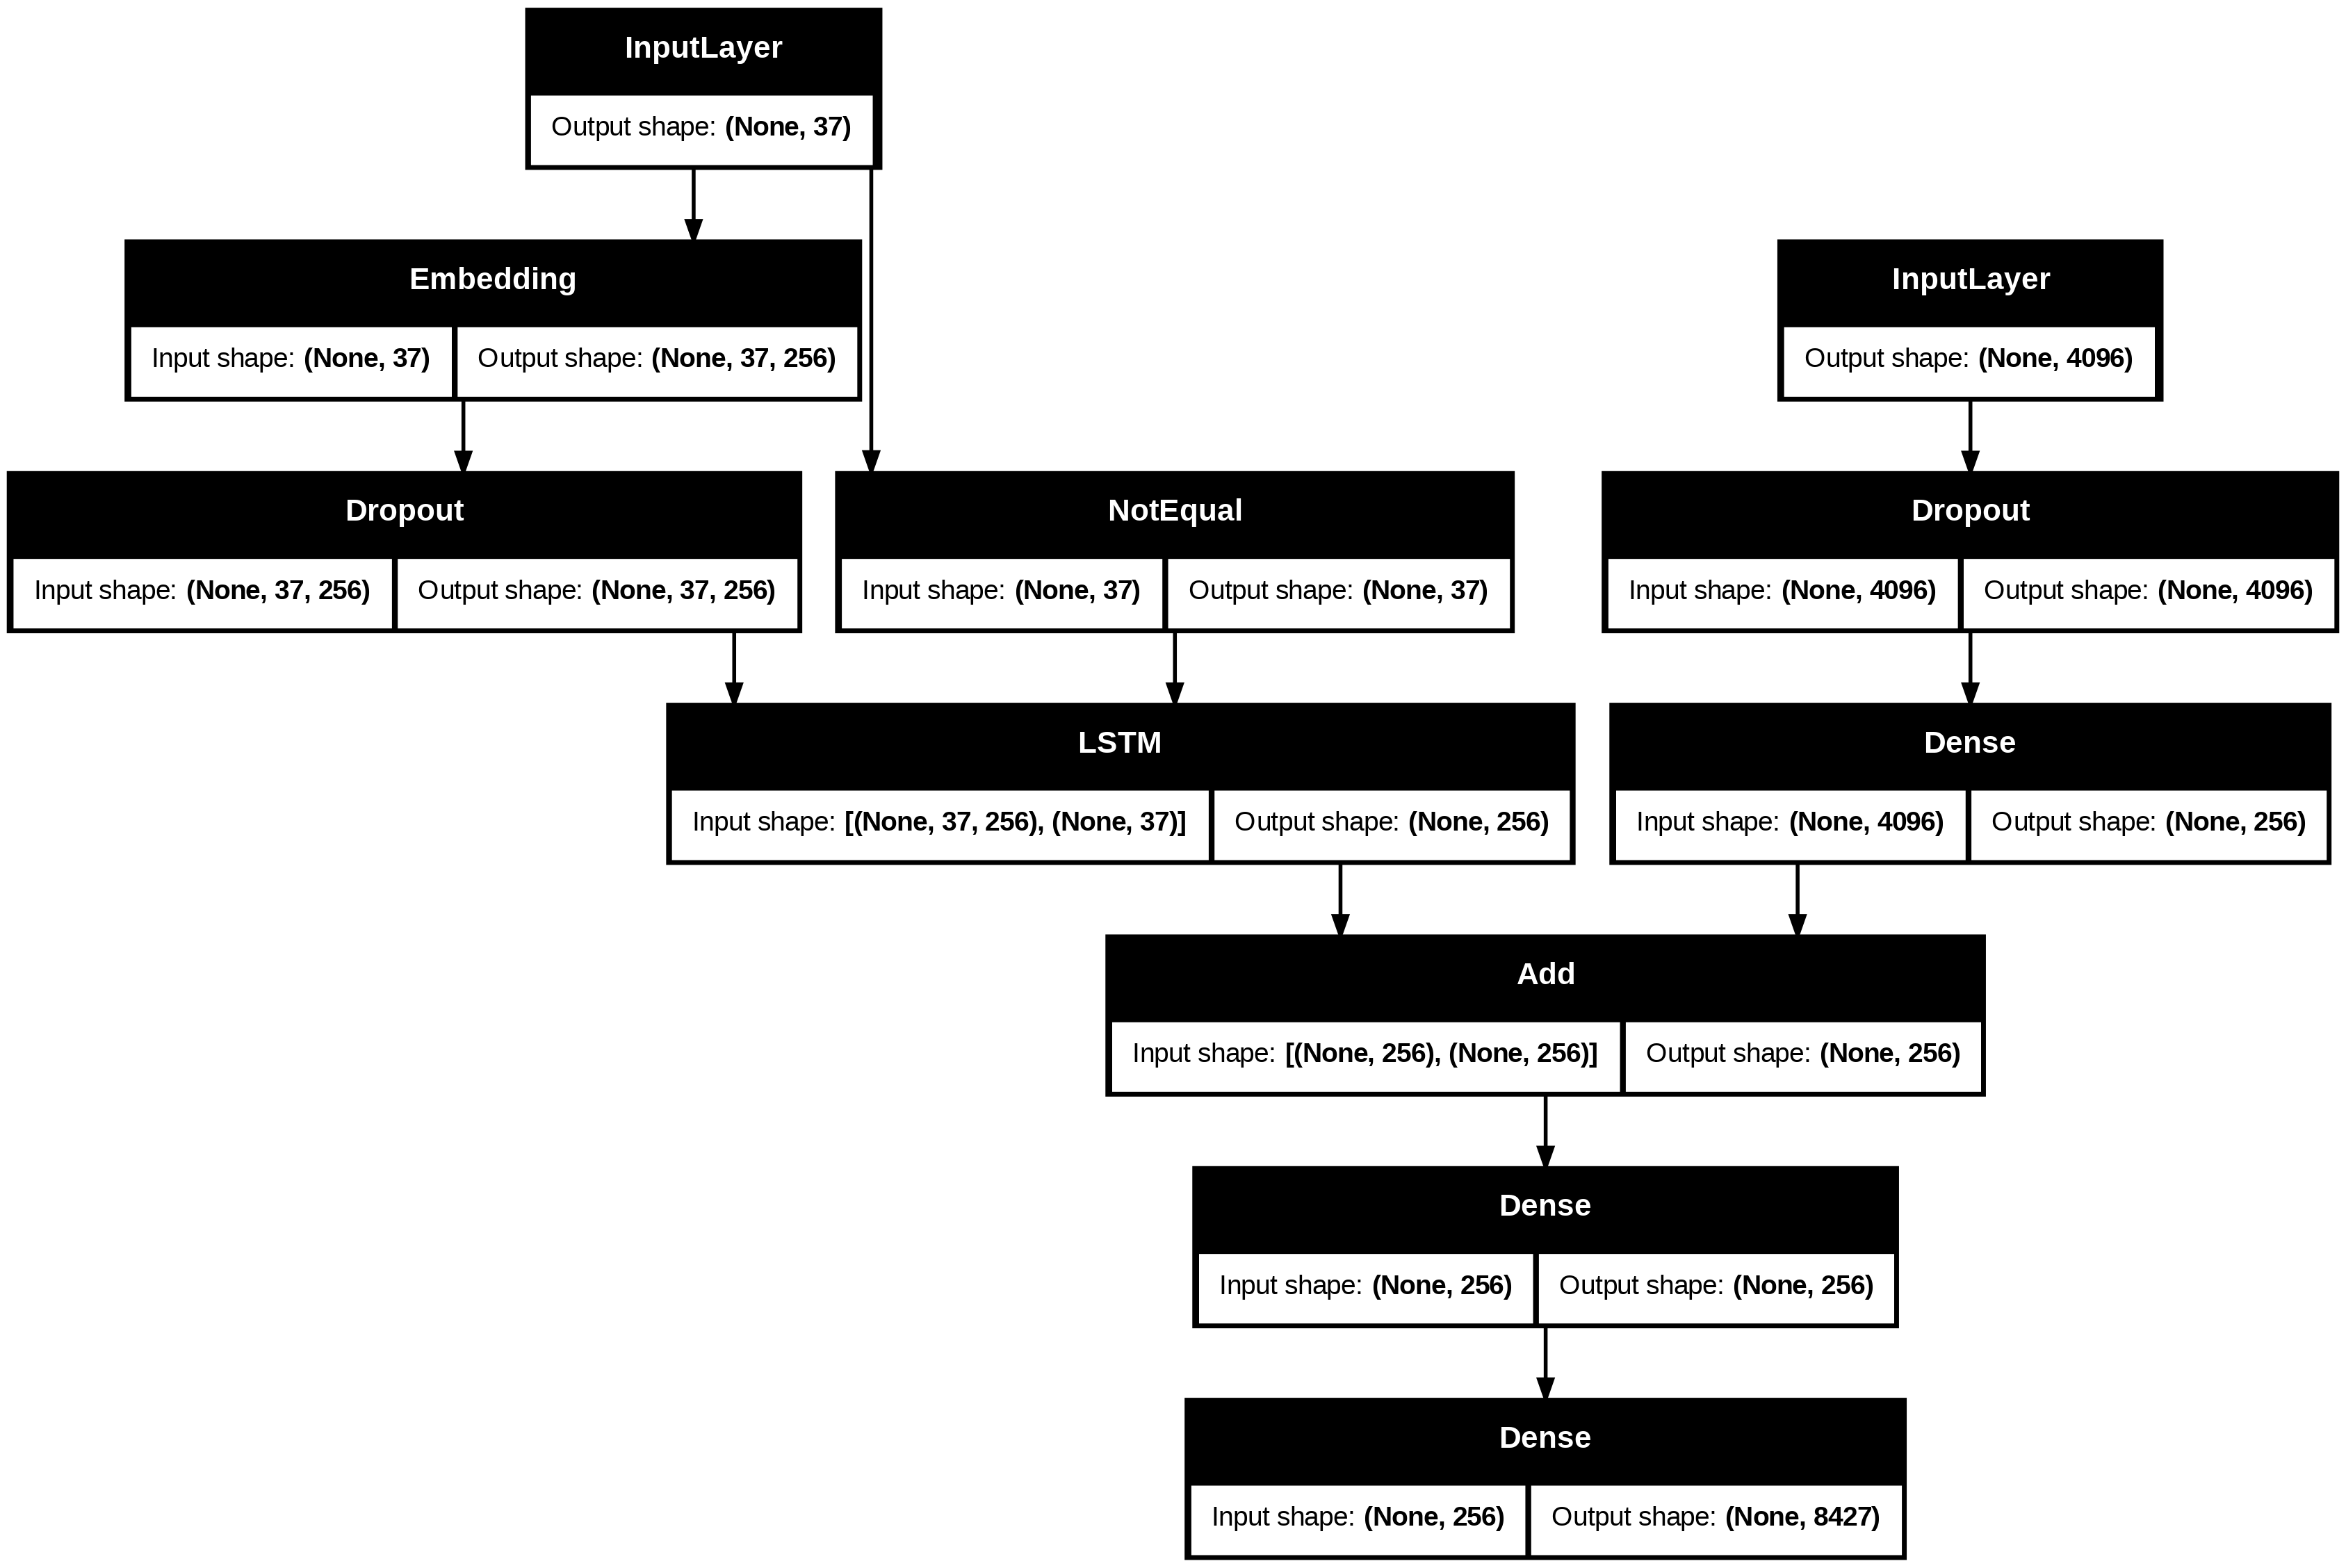

In [40]:
# plot the model
plot_model(model, show_shapes=True)

In [41]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)


227/227 ━━━━━━━━━━━━━━━━━━━━ 66s 269ms/step - loss: 5.1229
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 265ms/step - loss: 3.4432
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 264ms/step - loss: 3.0272
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 265ms/step - loss: 2.7803
227/227 ━━━━━━━━━━━━━━━━━━━━ 61s 267ms/step - loss: 2.6066
227/227 ━━━━━━━━━━━━━━━━━━━━ 61s 267ms/step - loss: 2.4765
227/227 ━━━━━━━━━━━━━━━━━━━━ 61s 267ms/step - loss: 2.3807
227/227 ━━━━━━━━━━━━━━━━━━━━ 61s 267ms/step - loss: 2.3092
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 266ms/step - loss: 2.2432
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 265ms/step - loss: 2.1866
227/227 ━━━━━━━━━━━━━━━━━━━━ 61s 268ms/step - loss: 2.1357
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 266ms/step - loss: 2.0853
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 266ms/step - loss: 2.0472
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 266ms/step - loss: 2.0107
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 263ms/step - loss: 1.9730
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 265ms/step - loss: 1.9447
227/227 ━━━━━━━━━━━━━━━━━━━━ 61s 268ms/step - loss: 1.91

In [ ]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

In [47]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [48]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length, padding='post')
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [49]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    # calcuate BLEU score
    print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BLEU-1: 0.666667
BLEU-2: 0.348155
BLEU-1: 0.545455
BLEU-2: 0.286039
BLEU-1: 0.485714
BLEU-2: 0.246403
BLEU-1: 0.500000
BLEU-2: 0.238366
BLEU-1: 0.470588
BLEU-2: 0.244453
BLEU-1: 0.487500
BLEU-2: 0.281166
BLEU-1: 0.494505
BLEU-2: 0.297161
BLEU-1: 0.500000
BLEU-2: 0.303959
BLEU-1: 0.474138
BLEU-2: 0.282421
BLEU-1: 0.511278
BLEU-2: 0.322364
BLEU-1: 0.524476
BLEU-2: 0.333545
BLEU-1: 0.516129
BLEU-2: 0.329057
BLEU-1: 0.533742
BLEU-2: 0.342671
BLEU-1: 0.525714
BLEU-2: 0.333197
BLEU-1: 0.513369
BLEU-2: 0.327795
BLEU-1: 0.512438
BLEU-2: 0.328675
BLEU-1: 0.518018
BLEU-2: 0.321875
BLEU-1: 0.523605
BLEU-2: 0.331046
BLEU-1: 0.524793
BLEU-2: 0.329019
BLEU-1: 0.537255
BLEU-2: 0.334699
BLEU-1: 0.543396
BLEU-2: 0.337014
BLEU-1: 0.535714
BLEU-2: 0.331738
BLEU-1: 0.547619
BLEU-2: 0.348201
BLEU-1: 0.557756
BLEU-2: 0.357693
BLEU-1: 0.565916
BLEU-2: 0.369503
BLEU-1: 0.572327
BLEU-2: 0.375662
BLEU-1: 0.565350
BLEU-2: 0.369672
BLEU-1: 0.552326
BLEU-2: 0.359642
BLEU-1: 0.554930
BLEU-2: 0.362039
BLEU-1: 0.5521

In [62]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images","Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq endseq
startseq startseq little girl is sitting in front of large painted rainbow endseq endseq
startseq startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq endseq
startseq startseq there is girl with pigtails sitting in front of rainbow painting endseq endseq
startseq startseq young girl with pigtails painting outside in the grass endseq endseq
--------------------Predicted--------------------
startseq startseq little girl in pink dress is walking in the middle of an elaborate rainbow endseq


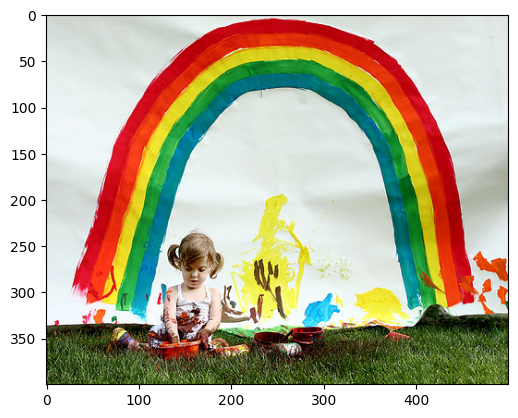

In [64]:
generate_caption("1002674143_1b742ab4b8.jpg")